# PointObject: Analysing pipeline for localisation super-resolution data
----
## Introduction:
PointObject was developed to analyse point localisation super-resolution data. The raw input to the pipeline are the localisations as generated by softwares like rapidstorm or others. If a super-resolved image is already available the first steps can be skipped and it is possible to directly begin with the contour fitting (see notebook in `example` folder). Implementating the pipeline in IPython notebooks should aid in documenting the analysis steps and will hopefully make the workflow as convenient as possible. This example file is intented to be used as template for the analysis of new measurements.

In the following a short description of the workflow will be given and one short example dataset will be analysed. Some of the functions will be described in here and further documentation can be found by looking at the source code itself.

## General workflow:
1. Given the raw localisation input the first step is to separate (or bin) the localisations to obtain a sequence of "images". The number of frames that needs to be taken will depend on the localisation density and critically influences the achievable resolution. A rolling window approach can be used to increase temporal "resolution" (see further down for more comments on that).

1. The next step is to identify the mitochondria in the super-resolution data. Due to the imaging conditions we typically observe significant background noise that needs to be filtered. For this the clustering algorithm [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) is used and the user needs to select the clusters corresponding the mitochondria of interest.

1. Describing shape changes of the mitochondria during scission events requires extracting the outline of the point-localisations that represent the mitochondria. This is achieved using a two-step procedure. The first step is to generate an image representation of the point-localisations which can then, in a second step, be analysed by contour fitting algorithms. Given the stochastic nature of point localisation super-resolution data [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) is used to generate a probability density function (pdf) that represents the underlying structure. This pdf can be sampled on a grid with high resolution (5nm) to generate a super-resolution "image". By using contour fitting (currently using [this](https://github.com/pmneila/morphsnakes) implementation) the outline of the localisations is determined.

1. The detected contour can then be used to calculate the curvature and extract curvature changes at user defined regions.

## Example:
In the following a walkthrough is given with detailed explanations of every step. To easily use this template it is advised to follow the folder and naming conventions detailed here **(still needs to be written)** .


---
### Step 1: Preparing the notebook
The very first thing that need to be done is to prepare the notebook to find the PointObject source code and load further modules. The UserWarning about the import error of the _tifffile extension can safely be ignored.

**Important:** If an ```ImportError``` is raised it is likely that the ```sys.path.insert()``` statement needs to be adjusted. It needs to point to the folder containing the PointObject source code.

In [1]:
%pylab inline
import sys, os
sys.path.insert(1, "../")
sys.path.insert(1, "../lib")

import numpy as np
from IPython.display import HTML

from PointObject import PointObject
from HTMLtable   import HTMLtable

htmlTable = HTMLtable()

Populating the interactive namespace from numpy and matplotlib


../lib/tifffile.py:237: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


---
### Step 2: Loading the data
The file that should be analysed is specified and the **PointObject() add wikipage** is initialised. See **here needs to be added** for the naming conventions.

```.makeMovie()``` takes the localisations and creates the super-resolution "images", i.e. it generates a sequence of images that constitue the movie of the changing mitochondria. The docstring says:
```python
    def makeMovie(nrFrames=2000, stepSize=500):
        """ 
        Bin the localisations into frames. Sampling density can be controlled
        by selecting the number of frames that should be grouped.
        
        Imaging live objects implies that the object moves and changes during
        acquisiton time. By selecting a time gap (i.e. nrFrames) in which the
        object can be assumed to be static, a snapshot at this "time point" can
        be generated and a super-resolution image can be created. To increase
        the temporal "resolution" stepSize can be specified which is the gap
        between the first frames of consecutive movie frames. If the stepSize
        is smaller than nrFrames there will consequently an overlap of data
        between consecutive points. This will however, effectivly increase the
        frames/sec of the movie that will be produced and will increase the
        chance of resolving the event of interest.
        
        Here a brief schematic of the movie frame generation:
        
            -------------------------------------------- (frames)
            | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |   |    (movie frames without overlap)
              |   |   |   |   |   |   |   |   |   |   |  (additional movie frames due to overlap)
        
        Input:
          nrFrames     How long should one movie frame be, i.e. number 
                       of original TIFF frames
          stepSize     Gap between to frames, if stepSize < nrFrames 
                       there will be overlap
        """
```

In [2]:
# Set the filename
subfolder = 'MitoTracker - single color'
fname     = os.path.join('150312_mito', \
                         'cell6_10ms_b9_p55_gain200_p2_1_MMStack.ome.txt' )

# Read the data and convert the localisations into the mito movie frames
mito = PointObject()
mito.loadFile(os.path.join('..','data',subfolder,fname)) # use an extra '..' here if needed
mito.makeMovie(3000, 1500)# usually take around 2000 ~ 3000 frames

Finished making the movie in: 0:00:00
Generated 8 frames


---
### Step 3: Select the region of interest (ROI)
There might only be a part of the full dataset that needs to be analysed and with this step computation time can be significantly reduced.
To enable user interaction with the IPython notebook Matplotlib widgets are used. Unfortunatly these widgets cannot be displayed within the browser since images in the browser are static and do not allow interactivity. To switch between display modes ```%pylab``` and ```%pylab inline``` are used. A more detailed explanation can be found **here needs to be added**

**Note:** By switching to ```%pylab``` the figures will no longer be documented in the notebook. It is good practice to call the ```show()``` function (if available) afterwards.

In [3]:
%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
mito.setFOV() # Note: The MatplotlibDeprecationWarning can be ignored

/home/niklas/bin/anaconda3/lib/python3.4/site-packages/matplotlib/backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


---
### Step 4: Using DBSCAN to remove background
One crucial step in the analysis is the removal of background localisations. There might be several sources of background localisations but, in general, the background should display a lower density than the structure of interest. For this reason the clustering algortithm [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) is used to select the localisations that belong to the structure of interest.

The selection of the clusters can be done directly from the notebook and we switch back to inline mode

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Clustering with DBSCAN is controlled by two parameters, ```eps``` and ```min_samples```. ```eps``` is specifing the distance between points so that they belong to the same cluster. ```min_samples``` determines the number of points needed to form a dense region, effectively controlling the minimal size that will be considered a cluster instead of noise.
```clusterData()``` will run clustering of each frame on a sinlge core making use of multi-core systems. By specifying the ```frame``` option, the user can restrict the clustering to specific frames to optimise the clustering parameters before running the full frame set.

```python
    def clusterData(self, eps, min_samples, frame=None, clusterSizeFiler=50, askUser=True):
        """
        Run DBSCAN to identify the objects of interest and supress noise.
        
        
        The density based clustering algorithm DBSCAN is used to cluster the
        point localisations within each movie frame. The user is then asked to
        select the clusters that correspond to the object of interest (multiple
        selections are allowed) and the selection will be kept and used for
        future calculations.
        
        Each movie frame will be run on one CPU core thus making use of multi-core
        systems. The user can restrict the frames that should be computed to
        optimse the clustering parameters.
        
        Input:
            eps (float):       The eps parameter of the sklearn DBSCAN implementation
            
            min_samples (int): The min_samples parameter of the sklearn DBSCAN implementation
                               For more details on the implementation see: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
            
            frame (int,None):  If not None specifies the frame that should used
            
            clusterSizeFiler (int): Display filter for small clusters. CLusters
                                    below the specified size will not be displayed
                                    
            askUser (bool):    Whether or not prompt the user to select the clusters
        
        
        """
```

Finished clustering in: 0:00:27


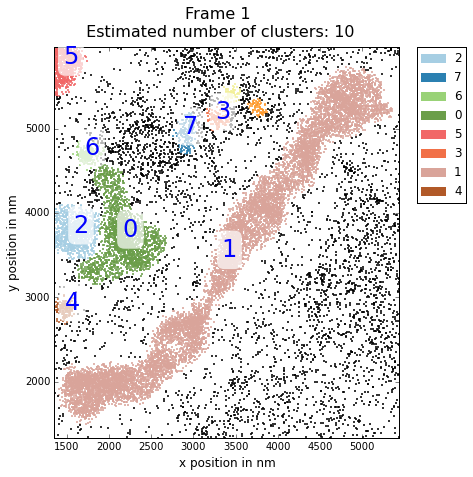

Which cluster(s) to keep? Please type integer value(s) 1




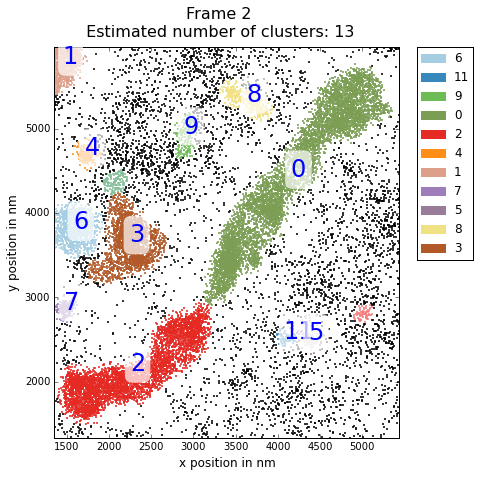

Which cluster(s) to keep? Please type integer value(s) 2 0




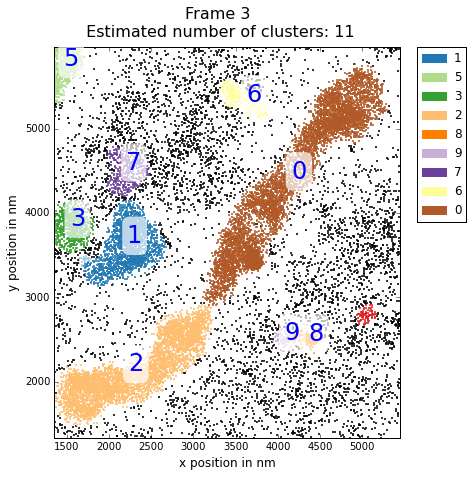

Which cluster(s) to keep? Please type integer value(s) 2 0




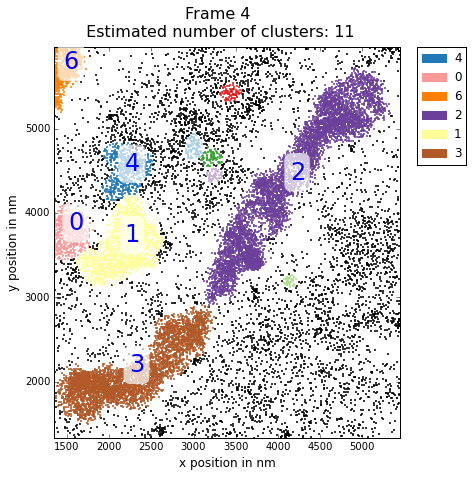

Which cluster(s) to keep? Please type integer value(s) 3 2




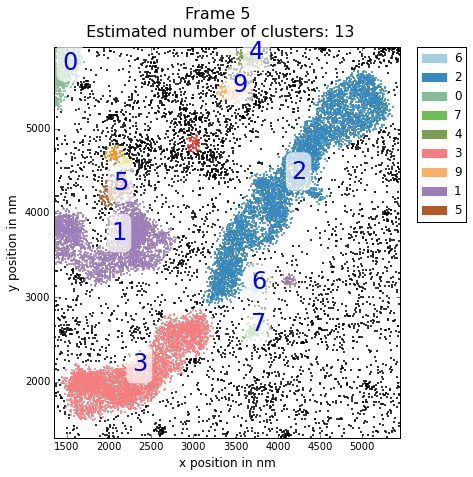

Which cluster(s) to keep? Please type integer value(s) 3 2




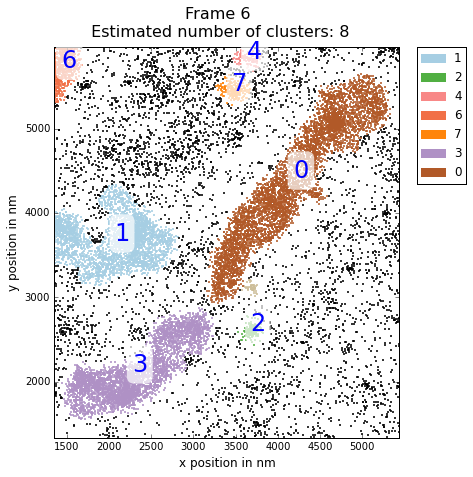

Which cluster(s) to keep? Please type integer value(s) 3 0




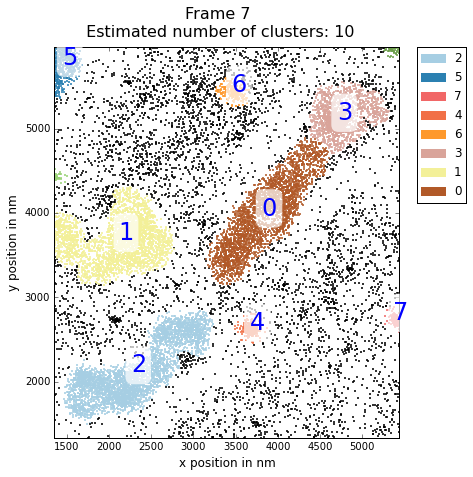

Which cluster(s) to keep? Please type integer value(s) 2 0 3




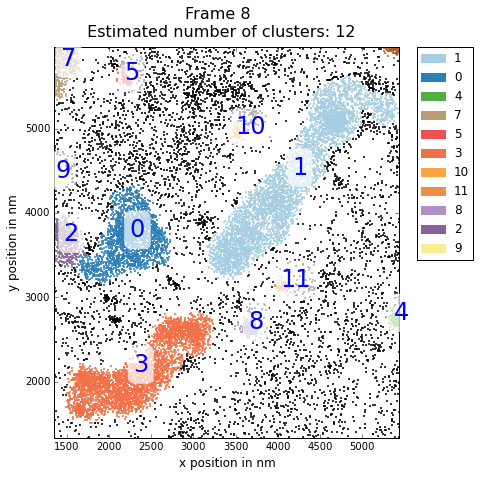

Which cluster(s) to keep? Please type integer value(s) 3 1



You selected the following clusters:
Frame 1: 1
Frame 2: 2 0
Frame 3: 2 0
Frame 4: 3 2
Frame 5: 3 2
Frame 6: 3 0
Frame 7: 2 0 3
Frame 8: 3 1


In [6]:
mito.clusterData(eps=80, min_samples=40, frame=None)

Get a better view on the clusters that were selected and ensure that we selected the clusters correctly. Blue points represent DBSCAN core points, red points are DBSCAN edge points.

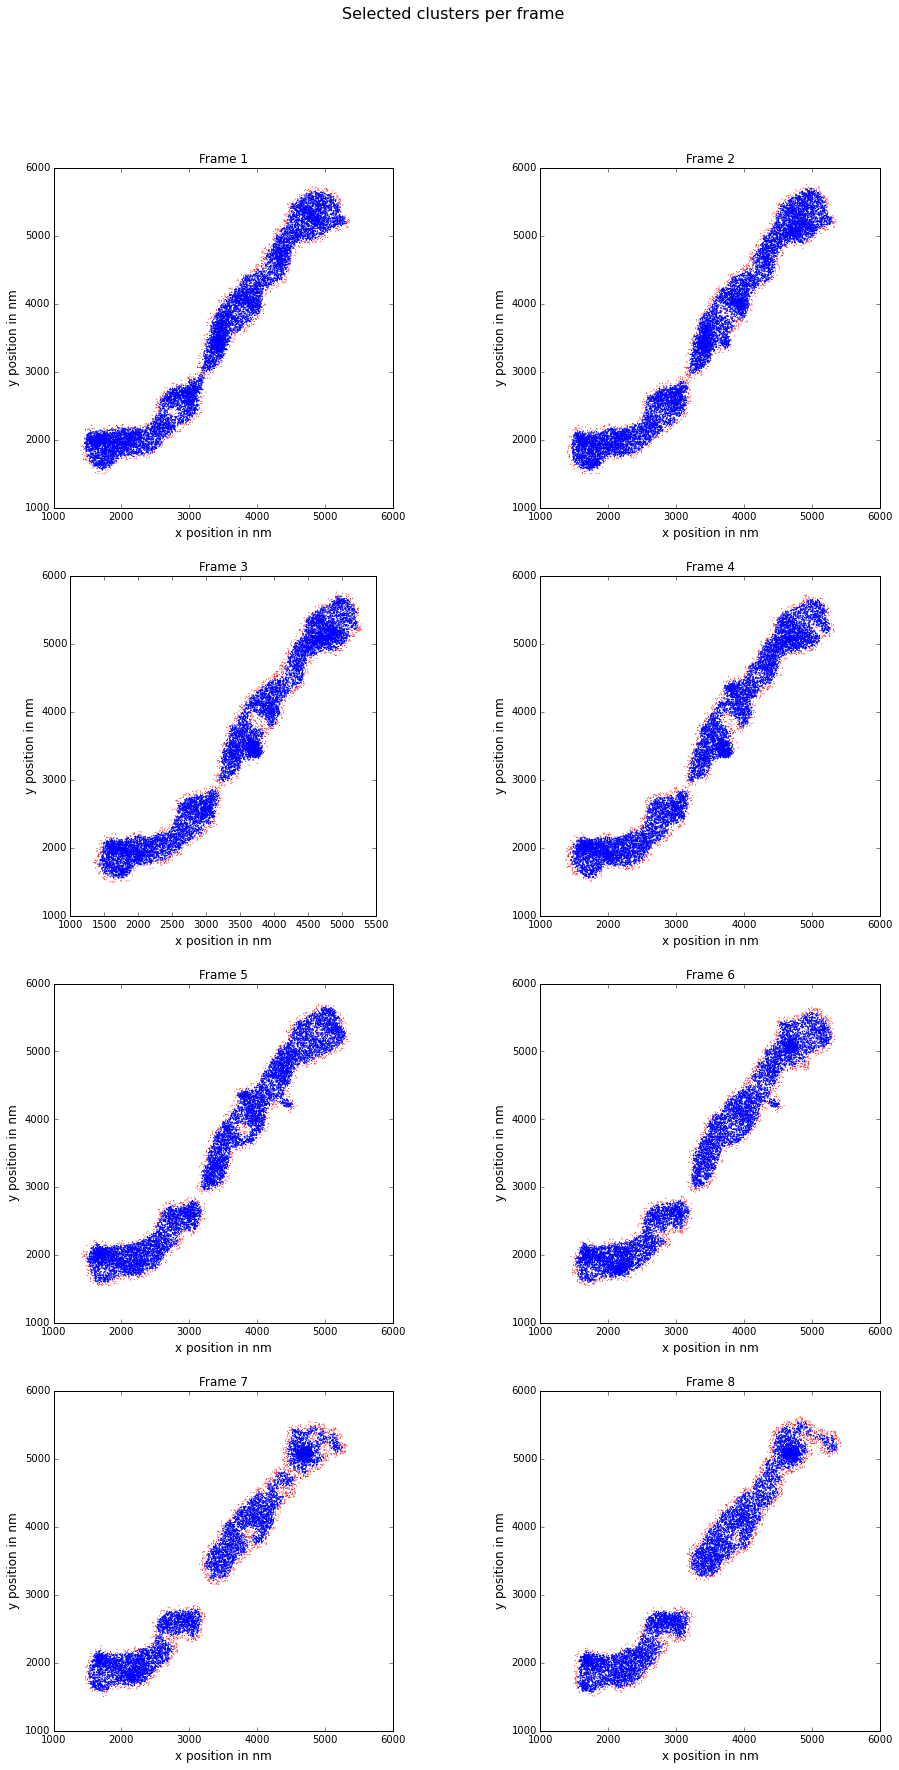

In [7]:
mito.cluster.showClusters()

Clustering of individual frames can be investigated with the cluster.checkCluster() function. The docstring says:
```python
    def checkCluster(self, frame=1, s=4, xlim=False, ylim=False, original=False):
        """
        Plot the selected clusters of individual frames
        
        Works like showClusters() but limits the plot to the selected frame.
        Allows additional restriction to user specified region to investigate
        the clustering result in more detail.
        
        Input:
            frame (int):      The frame that should be plotted
            
            s (int):          Size of the scatter points
            
            xlim (list):      The limits of the x axis
            
            ylim (list):      The limits of the y axis
            
            original (bool):  If set to True show the full field of view. 
                              Limits the plot to the ROI otherwise if one is set
                              
        """
```

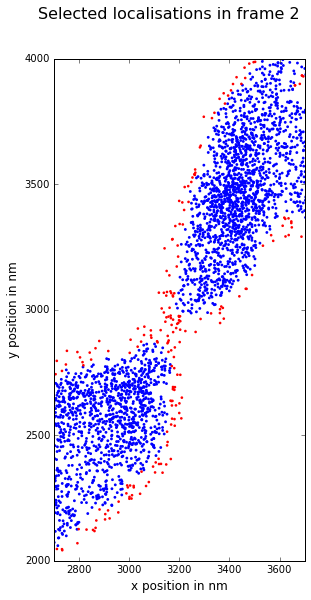

In [8]:
mito.cluster.checkCluster(2, 8, xlim=[2700,3700], ylim=[2000,4000])

At this point it can be advisible to decide if the edge points of the clustering (i.e. the red points) should be kept for the following analysis or if only the DBSCAN core points should be used. By default the pipeline will use both core as well as edge points but depending on the clustering result it might be worth to restrict the analysis to edge points.

In [ ]:
# If only core points should be used set
#mito.edgePoints = False

---
### Step 5: Finding the contour
After having removed the background localisations the next task is to find the outline that defines the shape of the point localisations. This is done in a two step process.
1. Calculate Kernel Density Estimate:
    Calculating the Kernel Density Estimation is mathematically very similar to rendering the localisations with gaussians. The resulting probability density function can be used to create a high-resolution image by sampling the pdf on a grid and by using the probability values as "pixels" of the image. By using a grid with spacing of 5nm we ensure that resolution is not an issue.
    If the bandwidth is not specified a cross-validation is used to estimate the optimal bandwidth parameter (cf. for example the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html)).

1. Find the contour using [morphological contour fitting](https://github.com/pmneila/morphsnakes)
    Unfortunately I don't know that much about it myself. But it seems very promising and also to work quite nicely. We will have to see.


----

Calculate the super-resolved image:
```python
    def calculateKDE(kernel='gaussian', bandwidth=None):
        """
        Calculate the Kernel Density Estimation.
        
        This will generate a high-resolution "image" of the localisations
        based on the kernel density estimate of the point localisations.
        
        If no bandwidth is specified an optimal bandwidth parameter is estimated
        using cross-validation. This is the default behaviour.
        
        Input:
            kernel (str):  Kernel to be used for the kernel density estimation
                           Possible values are 'gaussian' (default) and 'tophat'
            
            bandwidth (float,None):  The bandwidth for the kernel density estimation
                                     If set to None cross-validation will be used
                                     to find the optimal parameter.
                                     
        """
```

In [9]:
mito.calculateKDE()

Finished parameter estimation in: 0:03:02

Using the best estimated paramters:
bandwidth:	42.6136363636
kernel:	gaussian
algorithm:	kd_tree


Finished kernel density estimation in: 0:21:15


Now the best parameters for the contour fitting can be estimated. Contour fitting is computationally expensive and this step can thus be limited to a single frame. There are three relevant parameters, i.e. ```smoothing```, ```lambda1```, and ```lambda2```. We can choose some parameters and **all** possible combinations will be run on a single frame. The computation time will increase rapidly with increasing number of parameter choices!

```python
    def findFittingParameters(frame, smoothing, lambda1, lambda2, iteration=1000, \
                              scatter=True, s=10, alpha=0.8, xlim=False, ylim=False):
        """
        Find the best parameters for the morphological contour fitting algorithm.
        
        Running the morphological contour fitting algorithm is computationally
        expansive. In order to not have to optimise the parameters on all frames
        and to have a direct comparison of the result this function may be used.
        By specifing the desired parameters in list() objects, the full
        combination of parameters is evaluated on a single frame.
        
        Input:
            frame (int):  The frame that should be used
            
            smoothing (list):  The smoothng parameters that should evaluated.
                               Note: the values must be integers in a list!
            
            lambda1 (list):    The lambda1 parameters that should be evaluated.
                               Note: the values must be integers in a list!
            
            lambda2 (list):    The lambda2 parameters that should be evaluated.
                               Note: the values must be integers in a list!
            
            iterations (int):  The number of iterations the contour fitting
                               should run.
            
            scatter (bool):    Plot the localisation data
            
            s (int):           Size of the scattter points
            
            alpha (float):     Set the transparancy of the scatter points
                               (cf. matplotlib documentation for more details)
            
            xlim (list):       Limit the x range of the plot. Must be list of
                               length 2 with lower limit as first value and
                               upper limit as second value.
            
            ylim (list):       Limit the y range of the plot. (see also xlim)
        """
```

In order to have a better view on the scission site, we will restrict the view on a small region by specifing the ```xlim``` and ```ylim``` arguments.

Testing 8 parameter combinations
Finished contour parameter screen: 0:59:17


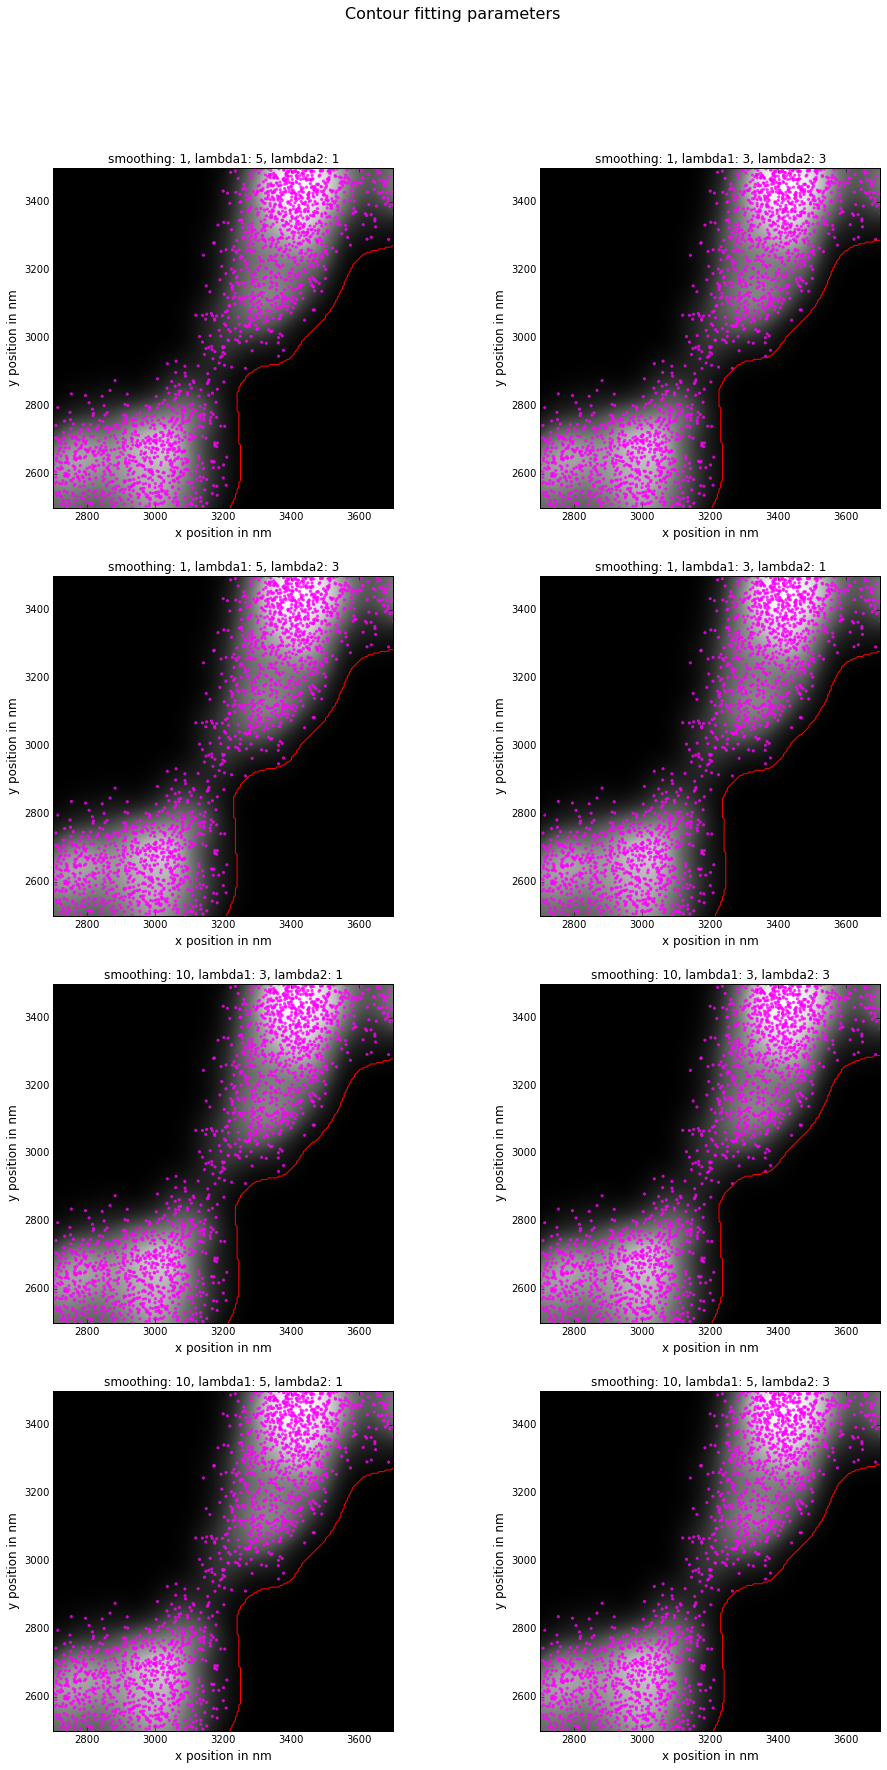

In [10]:
frame = 2          # the frame that will be used for optimisation
smoothing = [1,10] # the smoothing parameters to check
lambda1   = [3,5]  # the lambda1 parameters
lambda2   = [1,3]  # as above

mito.contour.findFittingParameters(frame, smoothing, lambda1, lambda2, xlim=[2700,3700], ylim=[2500,3500])

To run the contour fitting on all frames we invoke again the function ```calculateContour()```, this time we do not need to run the kernel density estimation again. We can simply invoke the contour fitting directly.

Here the docstring:
```python
    def calculateContour(self, kernel='gaussian', bandwidth=None, iterations=1500, 
                         smoothing=2, lambda1=1, lambda2=1, kde=True, morph=True):
        """
        Contour finding based on a 2D kernel density estimate.and contour fitting.

        
        Find the contour of the selected point localisations. This is done in two
        steps. The first step is to generate a high-resolution "image" of the
        localisations. The second step is to find the contour via a morphological
        contour fitting algorithm (https://github.com/pmneila/morphsnakes).

        If no bandwidth is specified an optimal bandwidth parameter is estimated
        using cross-validation. This is the default behaviour.
        
        The contour fitting is controlled using three parameters, i.e. smoothing,
        lamda1, and lambda2. Here the description given in the original source code
        smoothing : scalar
            The number of repetitions of the smoothing step (the
            curv operator) in each iteration. In other terms,
            this is the strength of the smoothing. This is the
            parameter µ.
        lambda1, lambda2 : scalars
            Relative importance of the inside pixels (lambda1)
            against the outside pixels (lambda2).
        Furthermore the parameter iterations is used to select the number of
        iterations the contour fitting should run. If it did not converge yet,
        further steps might be excecuted by calling contour.advanceContourMorph()
        
        
        Input:
            kernel (str):  Kernel to be used for the kernel density estimation
                           Possible values are 'gaussian' (default) and 'tophat'
            
            bandwidth (float,None):  The bandwidth for the kernel density estimation
                                     If set to None cross-validation will be used
                                     to find the optimal parameter.
            
            iterations (int):  Number of steps the morphological contour fitting
                               algorithm should advance.
            
            smoothing (scalar):  See above

            lambda1 (scalar):    See above

            lambda2 (scalar):    See above
            
            kde (bool):  Run Kernel Density Estimation. Set to False if
                         calculateContour() has already been run and only the
                         contour fitting should be repeated.
            
            morph (bool):  Run the morphological contour fitting
            
        """
```

Finished contour fitting in: 0:29:35


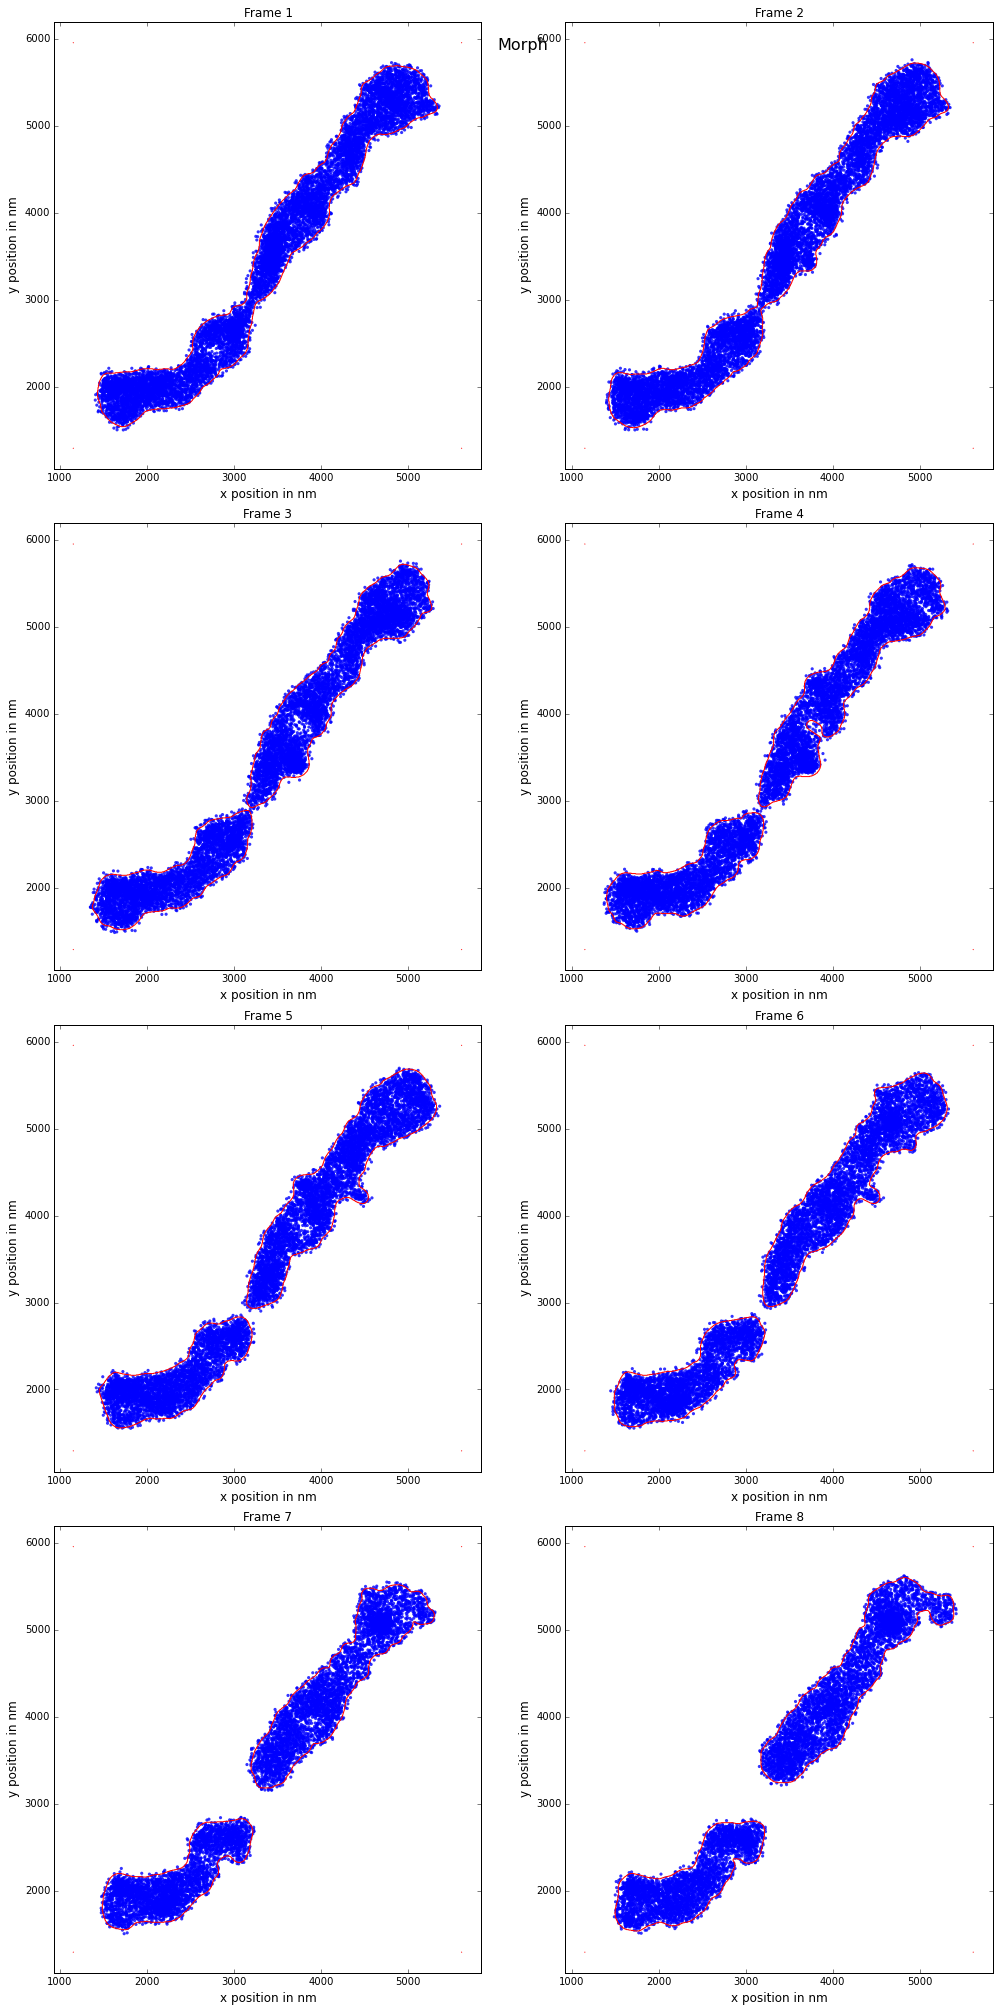

In [11]:
mito.calculateContour(smoothing=1, lambda1=5, lambda2=1, iterations=2000)

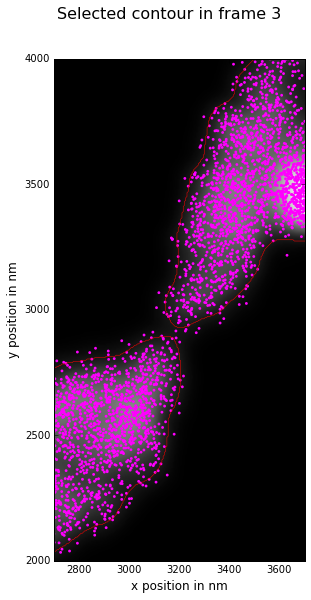

In [12]:
mito.contour.checkContour(3, xlim=[2700,3700], ylim=[2000,4000], lw=0.5, s=8, alpha=1.0, image=True, scatter=True)

---
### Step 6: Calculating the curvature

The contour that was determined above can now be used to calculate the curvature at a user selected site.
```python
    def calculateCurvature(smooth=True, window=2):
        """
        Calculate the curvature based on the expression for local curvature
        (see https://en.wikipedia.org/wiki/Curvature#Local_expressions )
        
        The contour path is stored internally as a sequence of points that build
        the contour path. Each point will obtain a curvature value which can
        lead to noisy data for each point. The curvature values at each point
        can be smoothed by averaging the curvature over neighbhoring points.
        This is done using a rolling window weighted with a gaussian to give 
        points further away from the center point a lower weight.
        
        
        Input:
            smooth (bool):  Smooth the curvature data using the gaussian weighted
                            rolling window approach.
            
            window (float):  Sigma of the gaussian (The three sigma range of the
                             gaussian will be used for the averaging with each 
                             localisation weighted according to the value of 
                             the gaussian).
        """
```

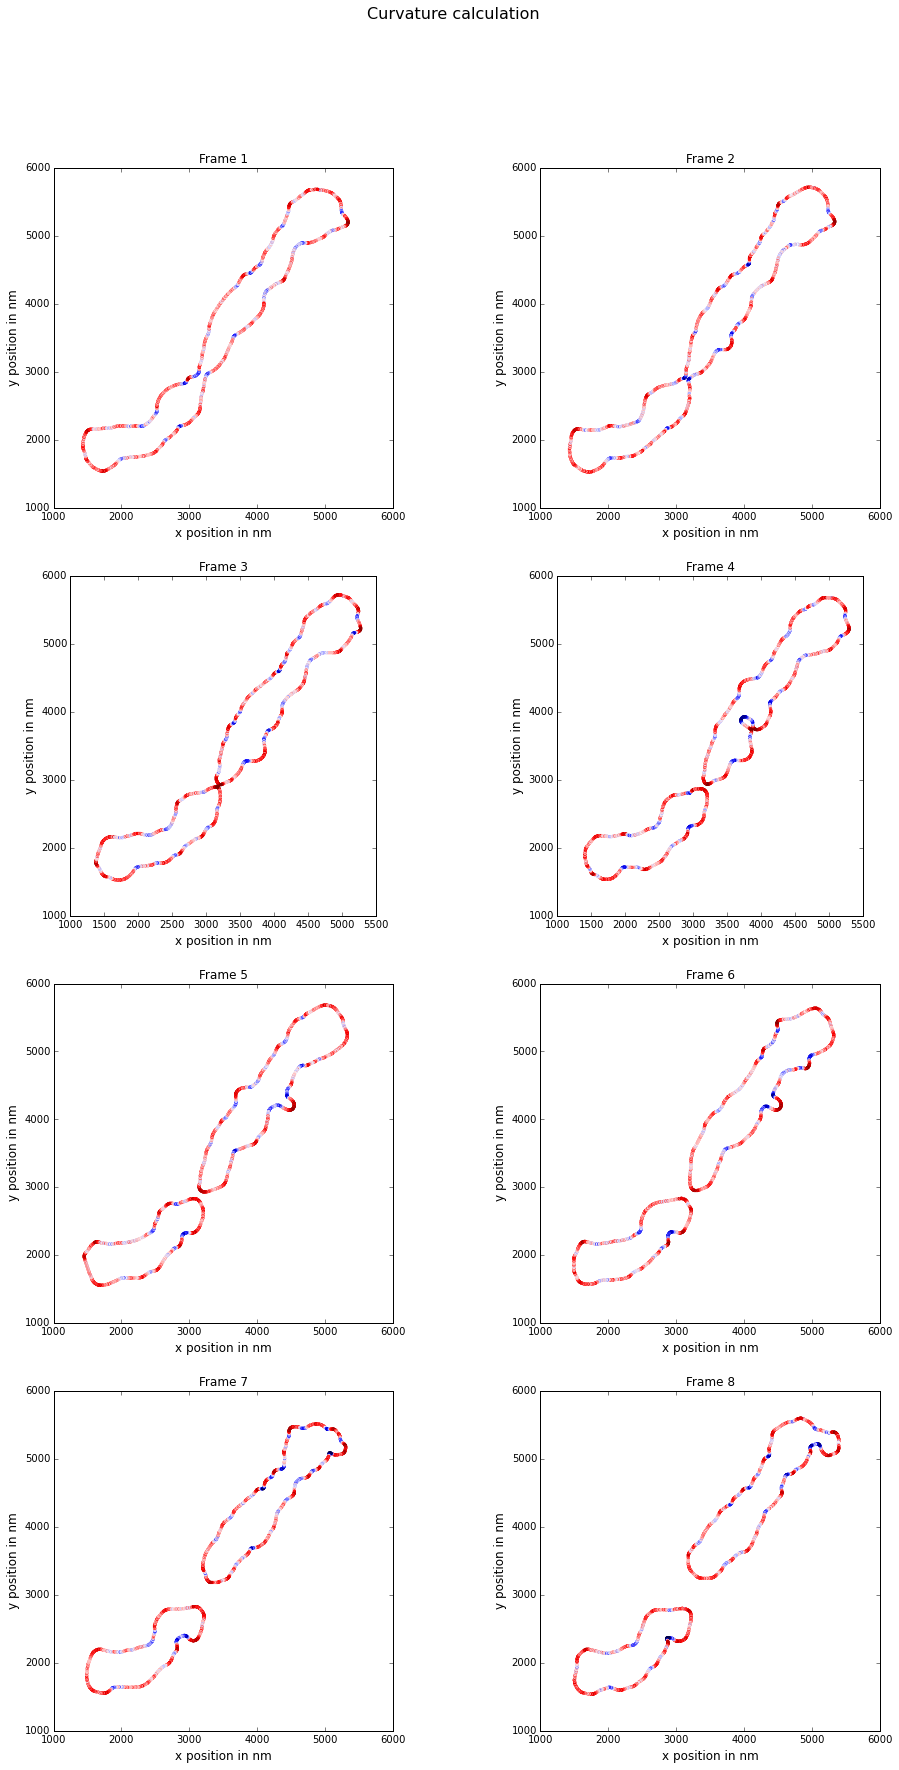

In [13]:
mito.calculateCurvature(smooth=True, window=3)

This calculated the curvature along the full contour of the object. However for observing mitochondria scission we are only interested in the invagination site. We can thus limit the length that should be used using the ```curvature.selectCurvature()``` command.

**Note:** The current pipeline uses the 95 percentile value of the selected range as measure for curvature. This value will depend on the length, i.e. on the amount of points on the contour, that the user selects. Currently I do not know an elegant way to enfore to perfect comparability of different selected regions.

```python
    def selectCurvature(xlim=False, ylim=False):
        """
        Let the user select the part of the contour that will be used for
        curvature measure.
        
        Note: requires user interaction and cannot be run in IPython inline mode
        
        It is important to be consistent with the way each side of the object
        is selected. Always start at the same side! If not, the analysis of the
        curvature value over time will be incorrect! See also showSelected()
        for more information.
        
        
        Input:
            xlim (list):       Limit the x range of the plot. Must be list of
                               length 2 with lower limit as first value and
                               upper limit as second value.
            
            ylim (list):       Limit the y range of the plot. (see also xlim)
        """
```
It is very important to remember that the regions that should be kept need to be selected consistently! If for example the top left side is selected first, it always needs to be selected first. After the break of the mitochondria this is "reset" but needs again to be consistent.
The pipeline keeps track of which segment was selected first and links the sides based on the user selection. If the user is not consistent, the linking will be wrong and the final plot of the curvature progession over time will be wrong and useless.

For the function to work we need to switch back to ```%pylab``` to allow user interaction.


In [14]:
%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [16]:
mito.curvature.selectCurvature(xlim=[2700,3700], ylim=[2000,4000])

/home/niklas/bin/anaconda3/lib/python3.4/site-packages/matplotlib/backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


To verify the selection and also for documenting the selection we call ```curvature.showSelected()```
```python
    def showSelected(xlim=False, ylim=False, s=10):
        """
        Plot the selected region of the contour that will be used for curvature
        estimation.
        
        The full contour will be shown in grey and the selected region will be
        color coded according the curvature value.
        
        Input:
            xlim (list):       Limit the x range of the plot. Must be list of
                               length 2 with lower limit as first value and
                               upper limit as second value.
            
            ylim (list):       Limit the y range of the plot. (see also xlim)
            
            s (int):           Size of the scatter plot points
        """
```

In the resulting plot the sides that the user selected are labelled with ```1``` and ```2``` respectively. The numbering of the sides shows how the curvature progession will be displayed in the following. If no consitency is found here the plot of the curvature progession will be wrong!

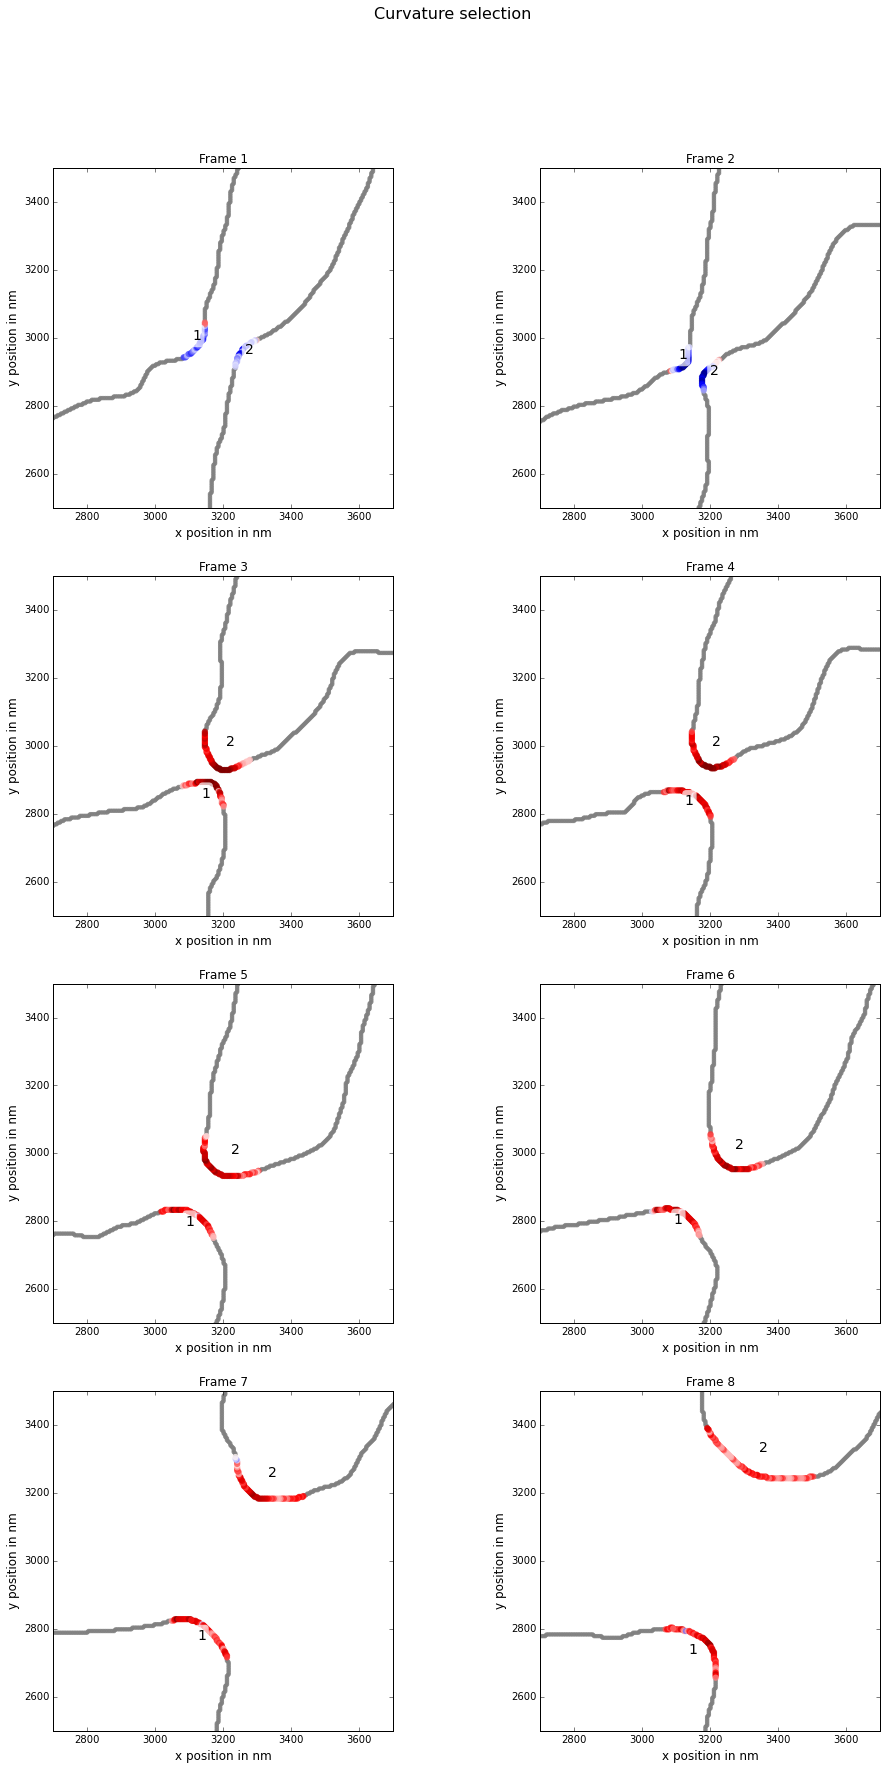

In [18]:
mito.curvature.showSelected(xlim=[2700,3700], ylim=[2500,3500], s=40)

---
### Step 7: Showing the result
Finally we can look at the result of the curvature calculation. First we obtain the 95 percentile of the curvature from the selected parts.
For each frame and for each side the corresponding curvature value is tabulated.

In [19]:
HTML( mito.curvature.table() )

Frame,1,2,Sum
1,0.17,0.21,0.38
2,0.32,0.28,0.61
3,-0.31,-0.31,-0.62
4,-0.19,-0.30,-0.49
5,-0.19,-0.24,-0.42
6,-0.21,-0.23,-0.45
7,-0.17,-0.19,-0.36
8,-0.22,-0.13,-0.34


We can generate a plot of the curvature progression to have a better visual feeling.

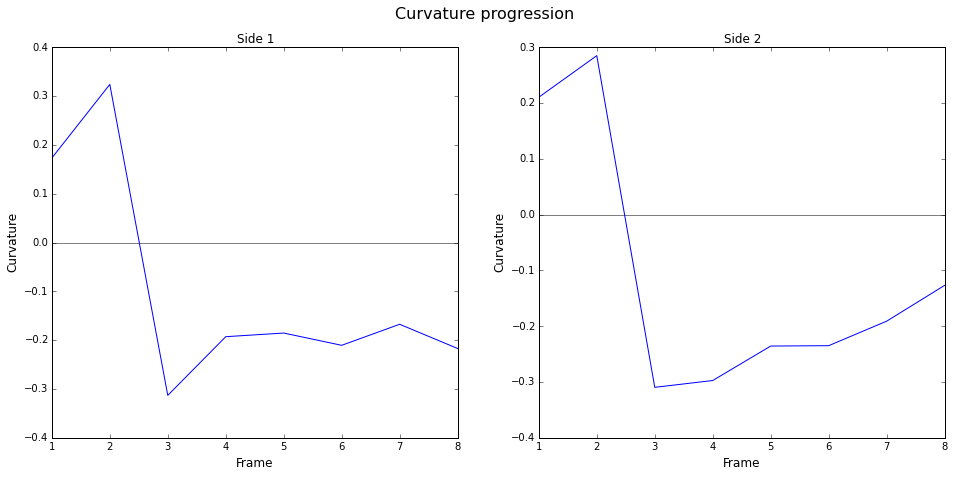

In [20]:
mito.curvature.plotCurvature()

---
### Step 8: Saving the object
If the IPython notebook is closed all saved variables will be lost. Only the content of the output cells will be kept. If individual steps should be repeated the whole notebook will have to be run from the beginning.

Some steps of this pipeline are computationally expansive and others require repetitive user input. The current state of the work can be saved anytime and loaded into another notebook. This way the calculation can be interrupted inbetween and the final result can be saved. Going back and fixing/changing single steps should (hopefully) be less work.

**Note:** Saving the object can be done anytime during the calculation. All previous steps will be saved and after loading the object you can continue where you left of.

In [21]:
# Saving the PointObject()
from utils import savePointObject
savePointObject(mito, '/tmp/my_mito_pointobject.p')

Saving to /tmp/my_mito_pointobject.p


In [ ]:
# Loading a PointObject()
from utils import loadPointObject
mito = loadPointObject('/tmp/my_mito_pointobject.p')

---
Exporting the clustered localisation data, the contour lines, and the curvature values can be done using the ```export()``` function.

```python
    def export(folderName=None):
        """
        Save the extracted structure (i.e. clusters), contour lines, and
        curvature values to a text file.
        
        Export the caluculated data to a folder. For each step of the calculation
        a single file will be created containing the frame number and the relevant
        values. See the header for more information.
        The output files will be named based on the input data file name if no
        folderName is given. The input file name will be appended by 
        "_clusterData.dat", "_contourData.dat", and "_curvatureData.dat" respectively.
        
        Input:
            folderName (str, None):  Export data into this folder (will be created if
                                     it does not exist. Existing files will be overwritten!)
        
        """
```

In [ ]:
# Export the calculated values
mito.export()